<a href="https://colab.research.google.com/github/claytonelbelTAMU/IPEC-638-Introduction-to-Data-Science/blob/main/project/ICPE_DS3_Spring_2025_Clayton_Elbel_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Electricity Load of Houston
###  ICPE 638 - Spring 2025

[Haoyu Niu](https://orcid.org/0000-0002-7052-8877), Texas A&M University.
Updated: Jan. 29, 2025.

**(30 points)**

### **Data Set**
A Cross-Domain Data Hub to Track the Impact of COVID-19 on U.S. Electricity Markets

https://github.com/tamu-engineering-research/COVID-EMDA

Particularly, we will use the electricity load data of Houston.

https://raw.githubusercontent.com/tamu-engineering-research/COVID-EMDA/master/data_release/ercot/ercot_houston_load.csv

### **Problem**
1. Carry out component decomposition for the electricity load of Houston

2. Perform KPSS and ADF Stationarity Tests, explain your results.

3. Build an ARIMA model with an optimal order (p, d, q)
   
4.  *(Extra credit)* Make a prediction for the next 30 days, plot it out, and explain your results.

## Download and Process Dataset
**Please don't change this section!**

You can use the dataframe `df` for the rest of your analysis.

In [1]:
DATA_URL="https://raw.githubusercontent.com/tamu-engineering-research/COVID-EMDA/master/data_release/ercot/ercot_houston_load.csv"

In [2]:
# import pandas, numpy and seaborn. sns.set() will set multiple theme parameters in one step for seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [3]:
# read the data and change the index to datetime index to facilitate the analysis.
df=pd.read_csv(DATA_URL)
df["date"] = pd.to_datetime(df["date"])
df.set_index(pd.to_datetime(df.date, format="%Y-%m-%d"), inplace=True)
df.drop(["date"], axis=1, inplace=True)
df.head(5)

,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,8791.8,8569.7,8326.4,8137.5,8011.9,7978.1,8057.1,8125.8,8289.2,8646.5,...,9957.6,9987.9,9943.9,10181.0,10583.5,10451.0,10230.6,10014.8,9667.7,9287.7
2017-01-02,8836.8,8588.2,8480.8,8506.0,8644.7,8887.0,9176.5,9323.8,9559.9,9602.7,...,10937.1,11037.0,10931.5,10859.0,11112.1,10893.9,10594.2,10196.7,9568.1,8935.5
2017-01-03,8516.6,8238.2,8102.8,8094.3,8265.7,8816.3,9615.5,10009.8,10102.3,10235.3,...,11022.6,10988.9,10883.8,10882.0,11092.8,10889.1,10577.2,10100.1,9488.8,8916.9
2017-01-04,8462.0,8316.5,8259.6,8336.3,8636.6,9357.1,10504.8,10955.0,10944.0,11119.8,...,10713.0,10602.9,10638.3,11099.4,11605.9,11578.6,11416.8,11010.9,10392.6,9784.5
2017-01-05,9472.0,9198.3,9051.1,9031.1,9237.9,9836.5,10685.2,10931.8,10841.5,10912.8,...,10692.5,10696.2,10791.9,11130.9,11378.8,11311.2,11194.9,10882.2,10416.8,9959.7


In [5]:
df['load']= df.sum(axis=1)
df = df[["load"]]
df.head(5)

,load
date,
2017-01-01,220989.4
2017-01-02,235680.6
2017-01-03,237534.1
2017-01-04,247560.4
2017-01-05,251129.3


<Axes: xlabel='date'>

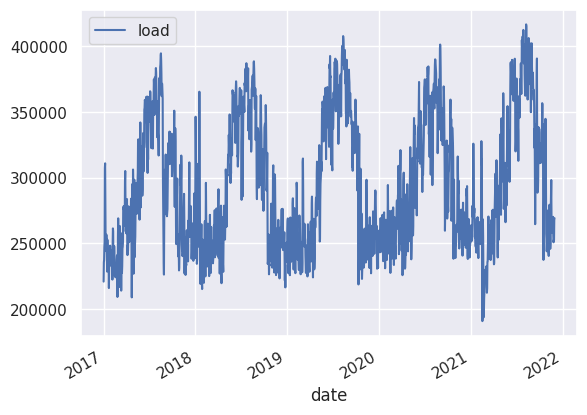

In [6]:
df.plot()

In [9]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima # This line requires the pmdarima package
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [11]:
# Calculate daily load by summing all hours
df['load'] = df.sum(axis=1)
df = df[["load"]]

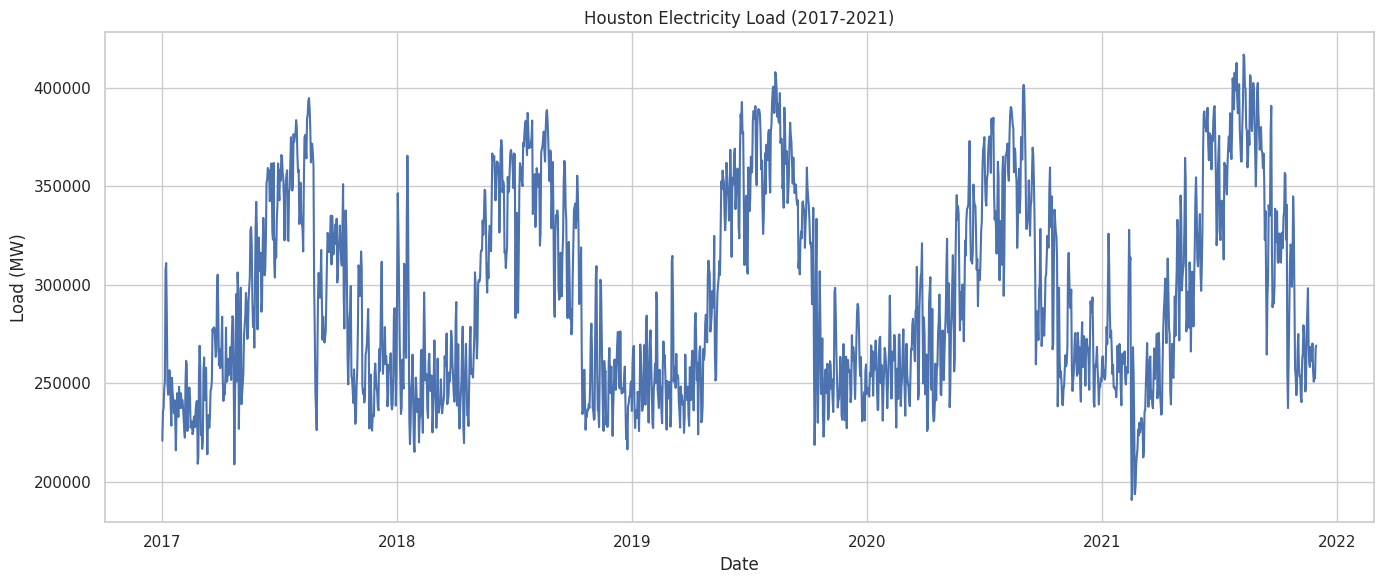

In [12]:
# We need a better visualization of the data than the plot line above
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['load'])
plt.title('Houston Electricity Load (2017-2021)')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Display basic statistics
print("Basic Statistics of the Dataset:")
print(df.describe())

Basic Statistics of the Dataset:
                load
count    1793.000000
mean   294935.667819
std     50019.807332
min    190900.100000
25%    252184.700000
50%    282682.600000
75%    337544.100000
max    416803.200000


In [14]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in the dataset:")
print(missing_values)


Missing values in the dataset:
load    0
dtype: int64


## Component Decomposition

### Why the Decomposition Model Over Multiplicative Model

For this analysis, using an additive decomposition model (Observed = Trend + Seasonality + Residual) is more appropriate than multiplicative. This choice is appropriate because the seasonal variations in electricity load appear consistent in magnitude over time, with no evidence that variance increases proportionally with the series level. Additive models work well when seasonal fluctuations remain relatively stable regardless of the overall trend level. This seems to be the case with our Houston electricity consumption data, where we do not observe exponential growth patterns.

### Annual Seasonal Decomposition

In [15]:
# Perform seasonal decomposition
# 365 days for annual seasonality
decomposition = seasonal_decompose(df['load'], model='additive', period=365)

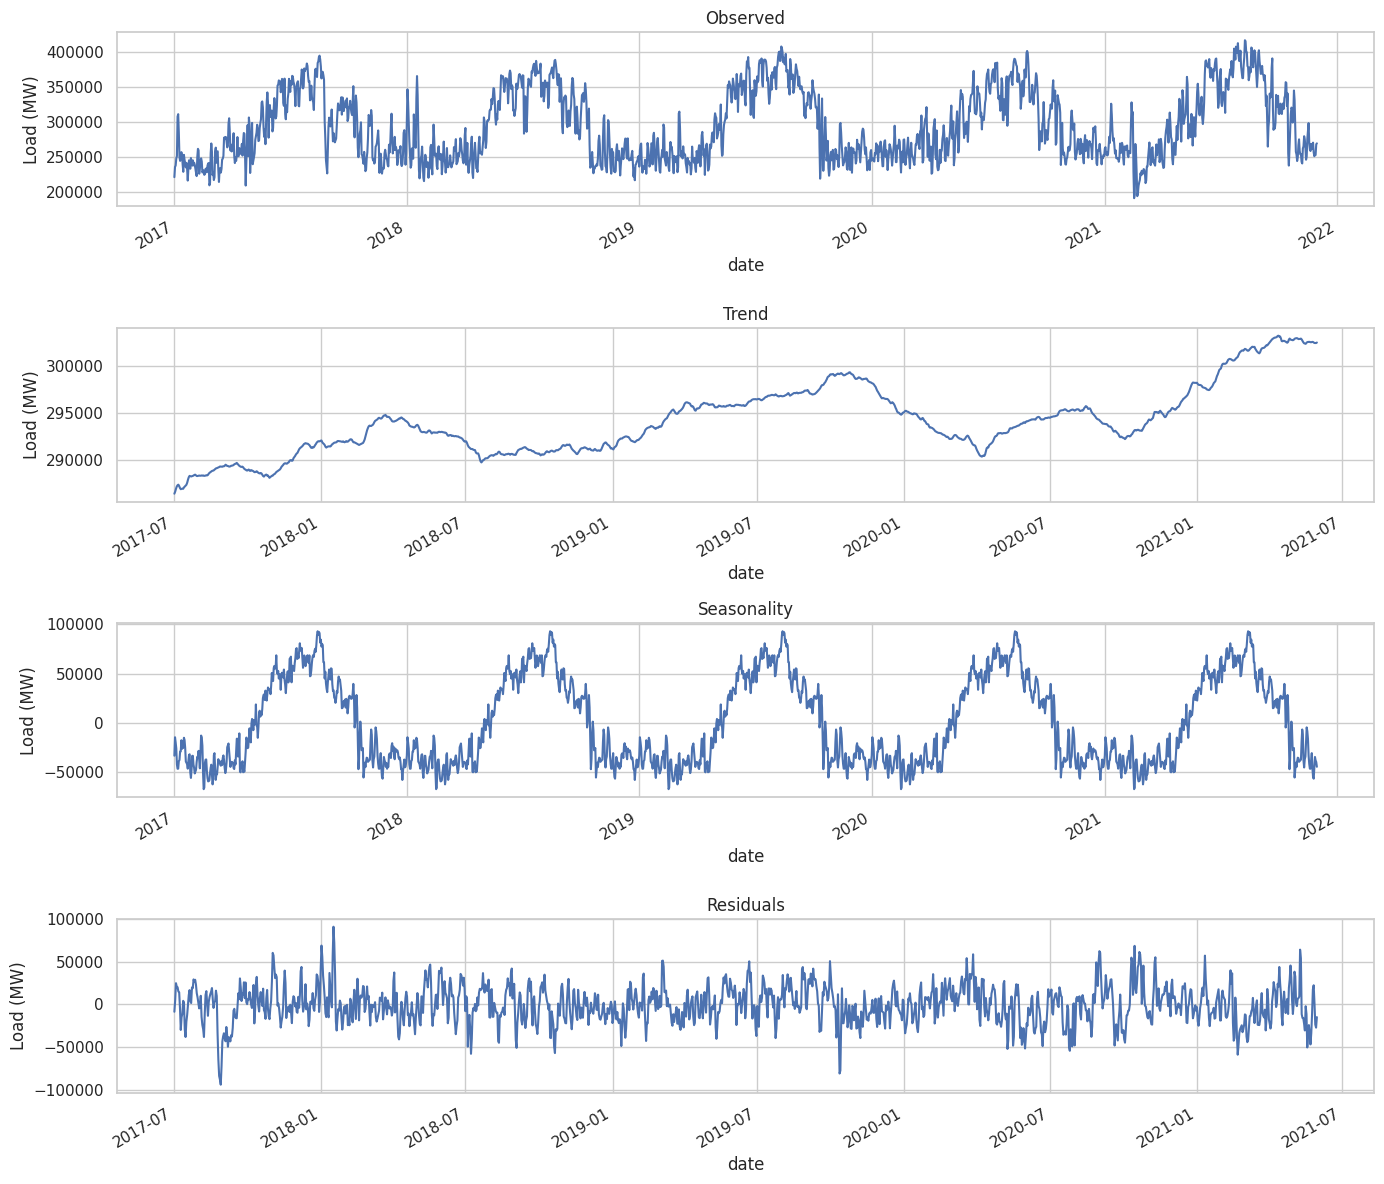

In [17]:
# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_ylabel('Load (MW)')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_ylabel('Load (MW)')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
ax3.set_ylabel('Load (MW)')

decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')
ax4.set_ylabel('Load (MW)')

plt.tight_layout()
plt.show()

### Weekly Decomposition to Capture Weekly Patterns

In [18]:
weekly_decomposition = seasonal_decompose(df['load'], model='additive', period=7)

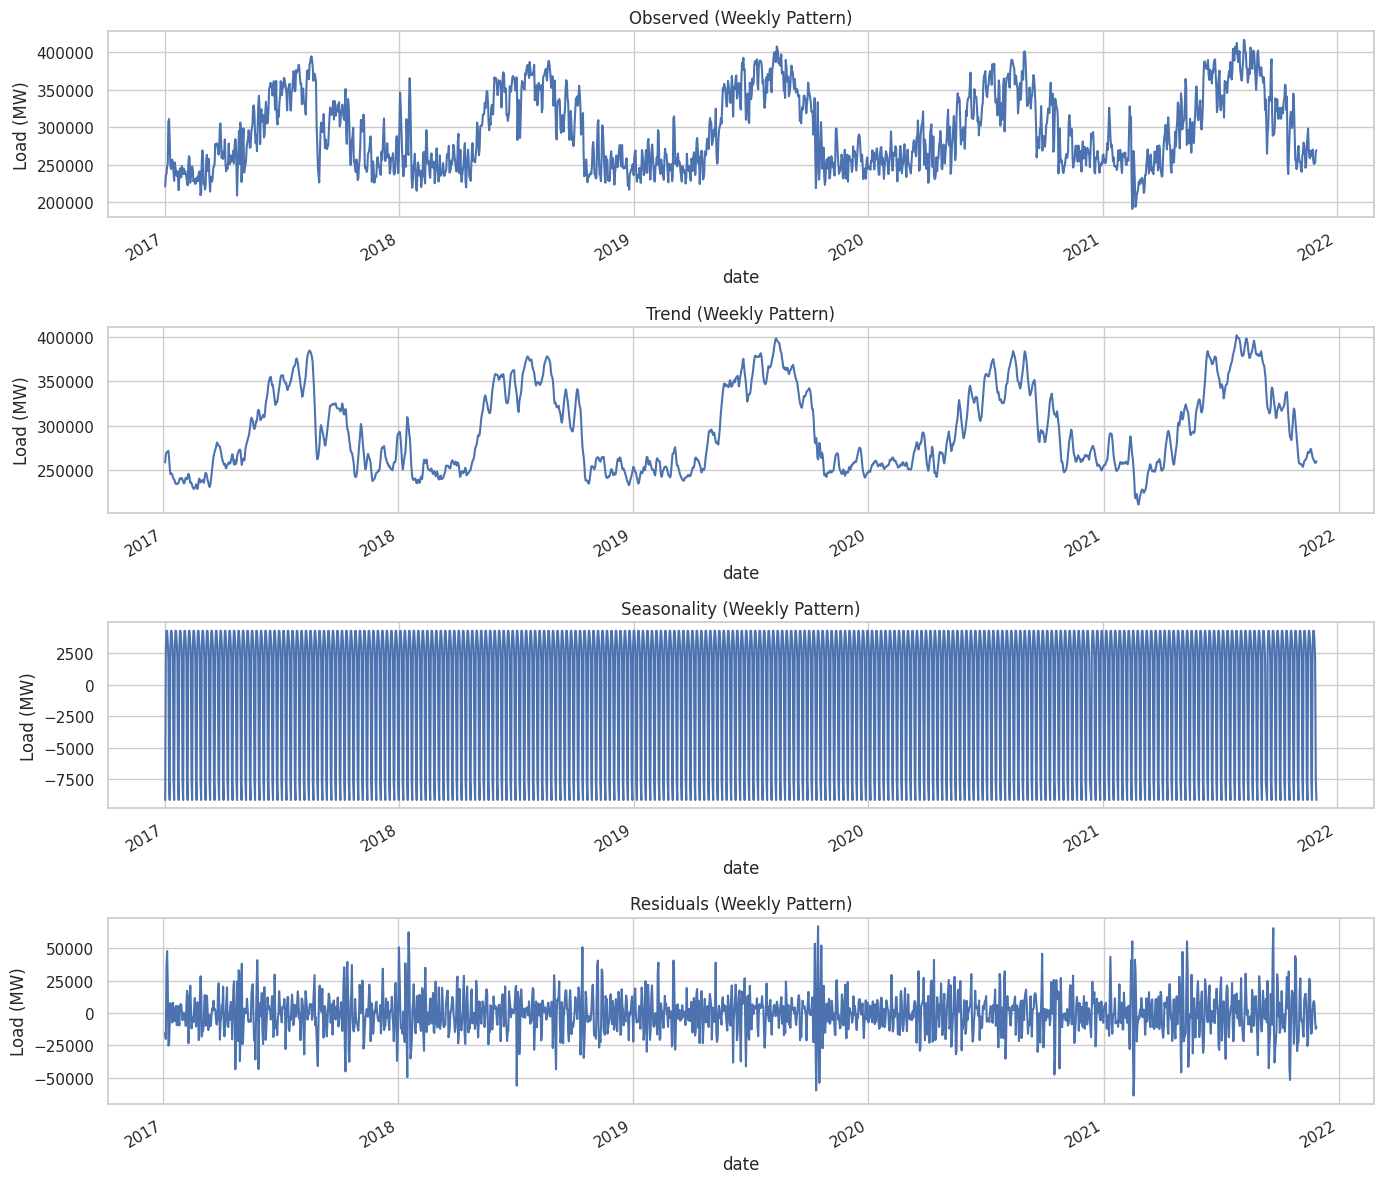

In [20]:
# Plot the weekly decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))

weekly_decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed (Weekly Pattern)')
ax1.set_ylabel('Load (MW)')

weekly_decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend (Weekly Pattern)')
ax2.set_ylabel('Load (MW)')

weekly_decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality (Weekly Pattern)')
ax3.set_ylabel('Load (MW)')

weekly_decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals (Weekly Pattern)')
ax4.set_ylabel('Load (MW)')

plt.tight_layout()
plt.show()

In [21]:
# Visualize weekly patterns
selected_period = df['2019-01-01':'2019-01-31']  # Just looking at January 2019


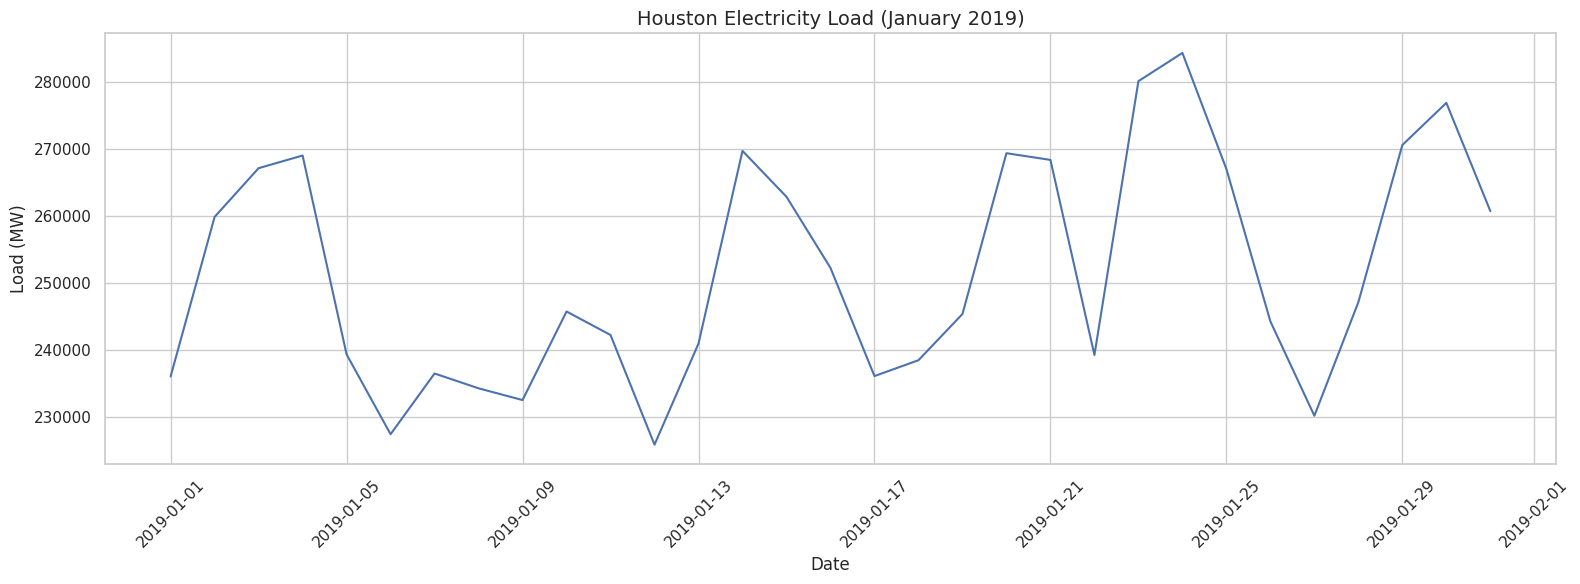

In [22]:
# Plot the selected period
plt.figure(figsize=(16, 6))
plt.plot(selected_period.index, selected_period['load'])
plt.title('Houston Electricity Load (January 2019)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Load (MW)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Get day of week for analysis
selected_period_with_dow = selected_period.copy()
selected_period_with_dow['day_of_week'] = selected_period_with_dow.index.day_name()

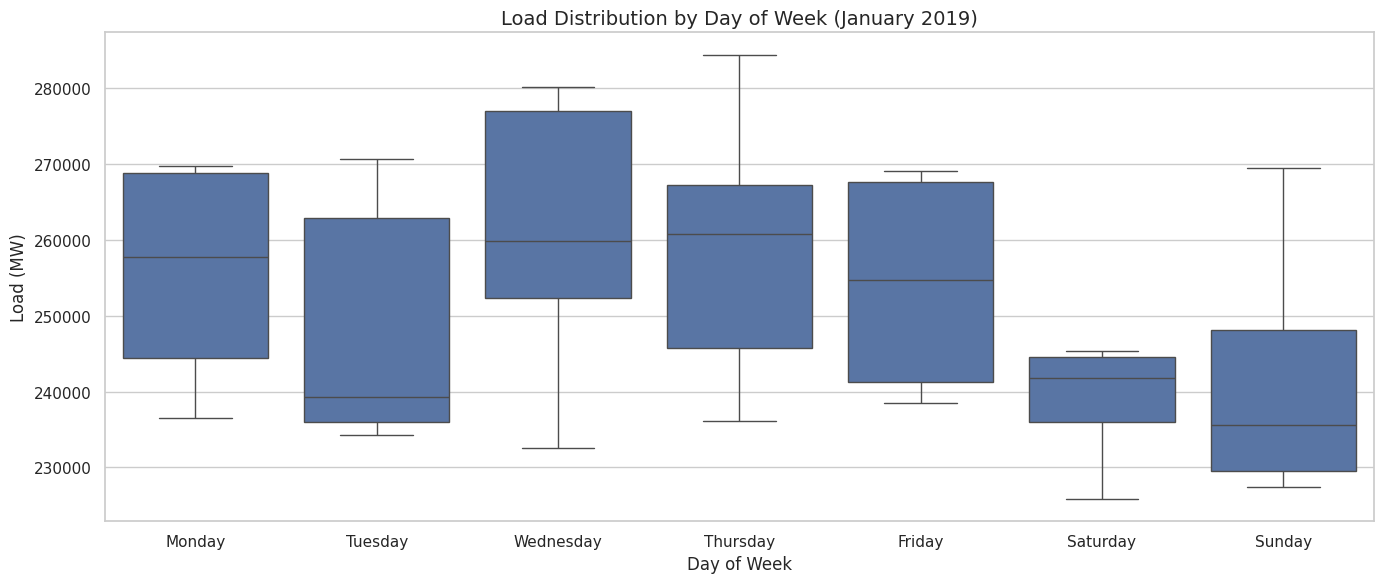

In [24]:
# Create a box plot to show load distribution by day of week
plt.figure(figsize=(14, 6))
sns.boxplot(x='day_of_week', y='load',
            data=selected_period_with_dow,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Load Distribution by Day of Week (January 2019)', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Load (MW)', fontsize=12)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

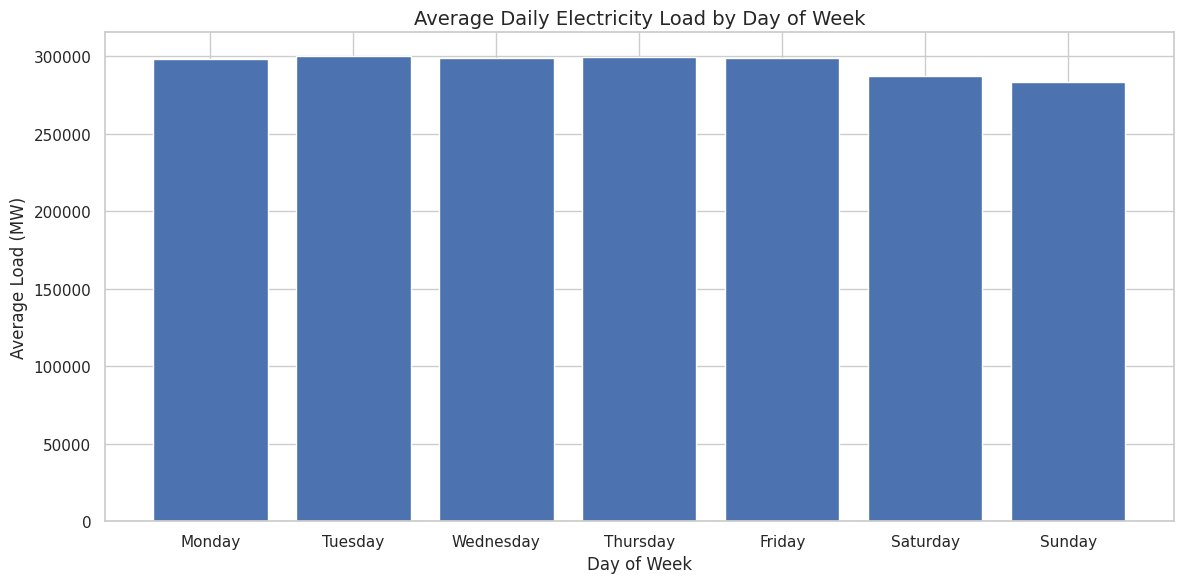

In [27]:
# Show the average daily pattern for a full week
weekly_pattern = df.groupby(df.index.dayofweek)['load'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
plt.bar(days, weekly_pattern.values)
plt.title('Average Daily Electricity Load by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Load (MW)', fontsize=12)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### Interpretation of Components

**Trend Analysis**

The trend component from the annual decomposition shows a gradual upward movement from 2017 through early 2019, followed by a peak around mid-2019 to early 2020. After this peak, there's a noticeable decline coinciding with the early COVID-19 pandemic period (early 2020), followed by recovery starting in mid-2020. By 2021, the trend climbs higher than previous levels, suggesting increased baseline electricity demand. This pattern likely reflects the changing economic conditions and shifting energy consumption behaviors during the pandemic—initial reduction followed by increased residential and industrial usage as society moved out of the pandemic.

**Seasonal Patterns Analysis**

The annual seasonal component reveals strong cyclical patterns with amplitudes of approximately 100,000 MW. These patterns clearly show summer peaks (likely due to air conditioning demand) and winter increases (heating requirements), with the lowest consumption in spring and fall when milder temperatures reduce heating and cooling needs. The consistency of these seasonal patterns confirms the predictable impact of weather on electricity consumption.

The weekly decomposition reveals distinct consumption patterns between weekdays and weekends. The additional visualizations provide clearer evidence of this phenomenon. The box plot for January 2019 shows significantly lower electricity load on Saturdays and Sundays, with medians approximately 20,000 MW below weekday levels. Among weekdays, Wednesday shows the highest consumption levels, while Tuesday has the most variable load pattern.

**Residual Analysis**

The residual components in both decompositions show irregular fluctuations that aren't captured by the trend or seasonal components. In the annual decomposition, several notable spikes appear, particularly around early 2018, mid-2019, and early 2021.

The weekly residuals have smaller magnitudes compared to the annual residuals, indicating that the weekly decomposition captures more of the fine-grained patterns. The randomness in the residuals suggests that the decomposition has effectively separated the systematic components (trend and seasonality) from the random noise and irregular events. However, the presence of some outliers points to extreme weather events or unusual consumption patterns that aren't fully captured by the seasonal patterns.

### Perform KPSS Test


In [29]:
kpss_test = kpss(df['load'], regression='c')

In [30]:
print("\nKPSS Test Results:")
print(f"KPSS Statistic: {kpss_test[0]}")
print(f"p-value: {kpss_test[1]}")
for key, value in kpss_test[3].items():
    print(f"Critical Value ({key}): {value}")


KPSS Test Results:
KPSS Statistic: 0.260098366318683
p-value: 0.1
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739


### Perform ADF Test


In [31]:
adf_test = adfuller(df['load'])

In [32]:
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
for key, value in adf_test[4].items():
    print(f"Critical Value ({key}): {value}")


ADF Test Results:
ADF Statistic: -2.686520681957906
p-value: 0.07639996511146552
Critical Value (1%): -3.4340519866364954
Critical Value (5%): -2.8631752211631247
Critical Value (10%): -2.5676405414939345


### Interpretation of Stationarity Tests


In [33]:
if kpss_test[1] < 0.05:
    print("\nKPSS Interpretation: The null hypothesis is rejected. The series is non-stationary.")
else:
    print("\nKPSS Interpretation: The null hypothesis cannot be rejected. The series is stationary.")



KPSS Interpretation: The null hypothesis cannot be rejected. The series is stationary.


In [34]:
if adf_test[1] < 0.05:
    print("ADF Interpretation: The null hypothesis is rejected. The series is stationary.")
else:
    print("ADF Interpretation: The null hypothesis cannot be rejected. The series is non-stationary.")


ADF Interpretation: The null hypothesis cannot be rejected. The series is non-stationary.


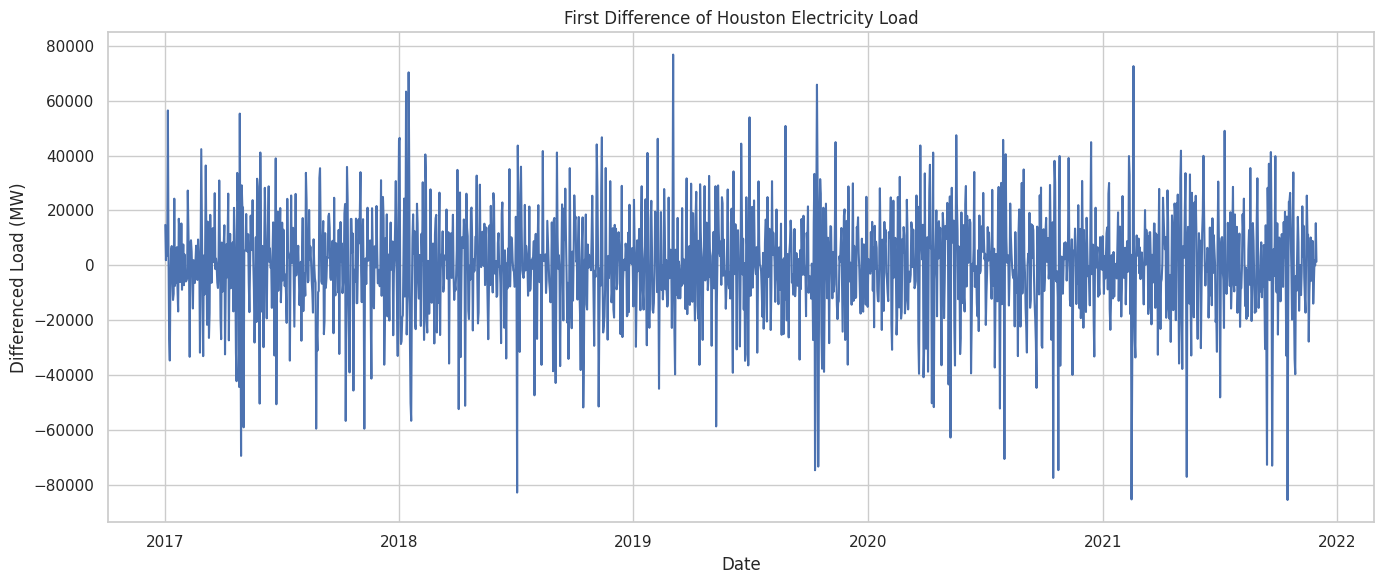

In [38]:
# Differencing to achieve stationarity
df['diff_load'] = df['load'].diff().dropna()

# Reset index after differencing to ensure alignment
df = df.reset_index().dropna()  # Resets the index and drops the row with NaN

# Plot the differenced series
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['diff_load'])  # Use the 'date' column for x-axis
plt.title('First Difference of Houston Electricity Load')
plt.xlabel('Date')
plt.ylabel('Differenced Load (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
# Test stationarity of the differenced series
kpss_diff = kpss(df['diff_load'].dropna(), regression='c')
adf_diff = adfuller(df['diff_load'].dropna())

print("\nKPSS Test Results (After Differencing):")
print(f"KPSS Statistic: {kpss_diff[0]}")
print(f"p-value: {kpss_diff[1]}")

print("\nADF Test Results (After Differencing):")
print(f"ADF Statistic: {adf_diff[0]}")
print(f"p-value: {adf_diff[1]}")


KPSS Test Results (After Differencing):
KPSS Statistic: 0.06299737947021697
p-value: 0.1

ADF Test Results (After Differencing):
ADF Statistic: -12.178646081383434
p-value: 1.3676401303801288e-22


In [41]:
# Interpretation after differencing
if kpss_diff[1] < 0.05:
    print("\nKPSS Interpretation (After Differencing): The series is non-stationary.")
else:
    print("\nKPSS Interpretation (After Differencing): The series is stationary after differencing.")

if adf_diff[1] < 0.05:
    print("ADF Interpretation (After Differencing): The series is stationary after differencing.")
else:
    print("ADF Interpretation (After Differencing): The series is non-stationary after differencing.")



KPSS Interpretation (After Differencing): The series is stationary after differencing.
ADF Interpretation (After Differencing): The series is stationary after differencing.


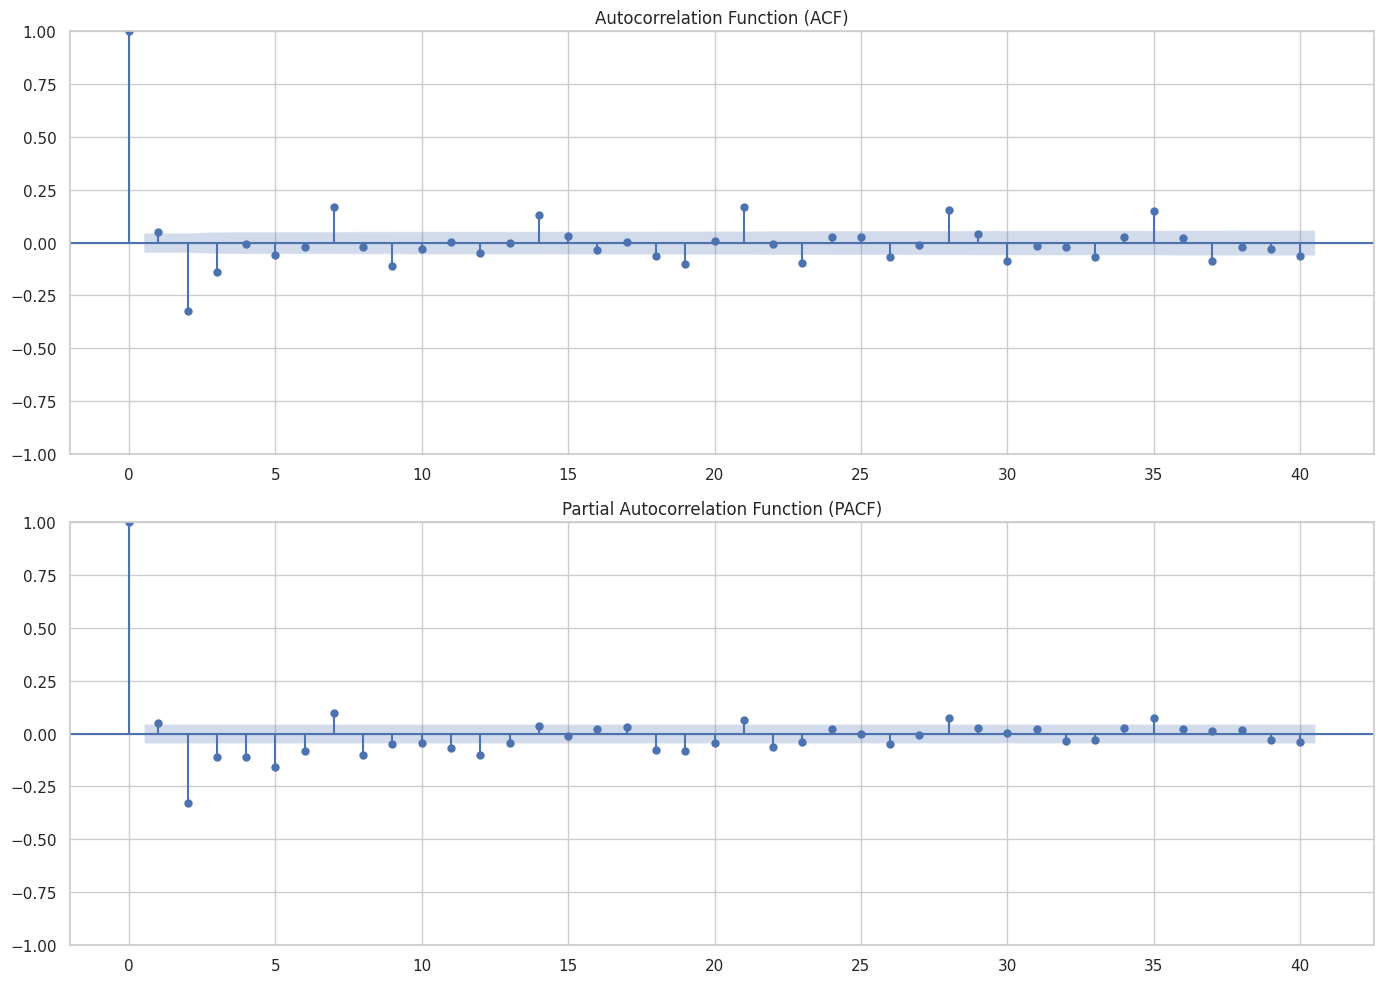

In [42]:
# Plot ACF and PACF to help determine p and q values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(df['diff_load'].dropna(), ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(df['diff_load'].dropna(), ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

**Test Results for Original Series**

KPSS Test Results:

- KPSS Statistic: 0.260098
- p-value: 0.1
- Critical Value (5%): 0.463

ADF Test Results:

- ADF Statistic: -2.686521
- p-value: 0.07640
- Critical Value (5%): -2.863175

The KPSS and ADF tests yield seemingly contradictory results for the original series. The KPSS test, with a p-value of 0.1 (greater than 0.05), fails to reject the null hypothesis that the series is stationary. Meanwhile, the ADF test, with a p-value of 0.07640 (slightly greater than 0.05), fails to reject its null hypothesis that the series has a unit root (is non-stationary). When tests provide conflicting results, we have to take the difference of the data as a precautionary measure.

**Test Results After Differencing**

KPSS Test Results (After Differencing):

- KPSS Statistic: 0.062997
- p-value: 0.1

ADF Test Results (After Differencing):

- ADF Statistic: -12.178646
- p-value: 1.368e-22

After applying first differencing, both tests align in their conclusions. The KPSS test maintains its high p-value, continuing to support stationarity. The ADF test now shows an extremely small p-value (1.368e-22), strongly rejecting the null hypothesis of non-stationarity.

**Plotting ACF and PACF**

The ACF and PACF plots of the differenced series show significant spikes at lags 7, 14, 21, and 28, indicating weekly seasonal patterns. The ACF plot shows a quick decay after lag 1 with some significant spikes at seasonal intervals. At the same time, the PACF has significant negative values at lag 2 and several significant values at seasonal lags.

Based on these results, I conclude:

- The original series appears to be marginally non-stationary
- First differencing (d=1) successfully transforms the series to stationarity
- The presence of seasonal patterns suggests a seasonal component should be included in the ARIMA model
- The ACF and PACF patterns suggest considering low orders for both AR (p) and MA (q) components

##   ARIMA Model with optimal order (p, d, q)

#### Running the ARIMA Model

In [43]:
# Use auto_arima to find the optimal order
auto_model = auto_arima(df['load'],
                         start_p=0, start_q=0,
                         max_p=5, max_q=5, max_d=2,
                         seasonal=True, m=7,  # Weekly seasonality
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print("\nOptimal ARIMA Model:")
print(auto_model.summary())
print(f"Optimal ARIMA Order: {auto_model.order}")
print(f"Optimal Seasonal Order: {auto_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.77 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=40359.829, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=40317.171, Time=0.91 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=40317.171, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=40357.831, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=40357.488, Time=0.19 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=40297.699, Time=1.37 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.73 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=40300.925, Time=1.06 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=40125.723, Time=1.69 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=40146.902, Time=1.21 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=9.90 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=6.47 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=40105.4

In [44]:
# Get the optimal order parameters
p, d, q = auto_model.order

In [45]:
# Build the ARIMA model with the optimal parameters
arima_model = ARIMA(df['load'], order=(p, d, q))
arima_results = arima_model.fit()

In [46]:
# Print ARIMA model summary
print("\nARIMA Model Summary:")
print(arima_results.summary())


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                 1792
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -20040.116
Date:                Sat, 08 Mar 2025   AIC                          40094.233
Time:                        05:30:48   BIC                          40132.667
Sample:                             0   HQIC                         40108.424
                               - 1792                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8466      0.038     22.376      0.000       0.772       0.921
ar.L2         -0.3435      0.022    -15.447      0.000      -0.387      -0.300
ar.L3          0.1335      0.0

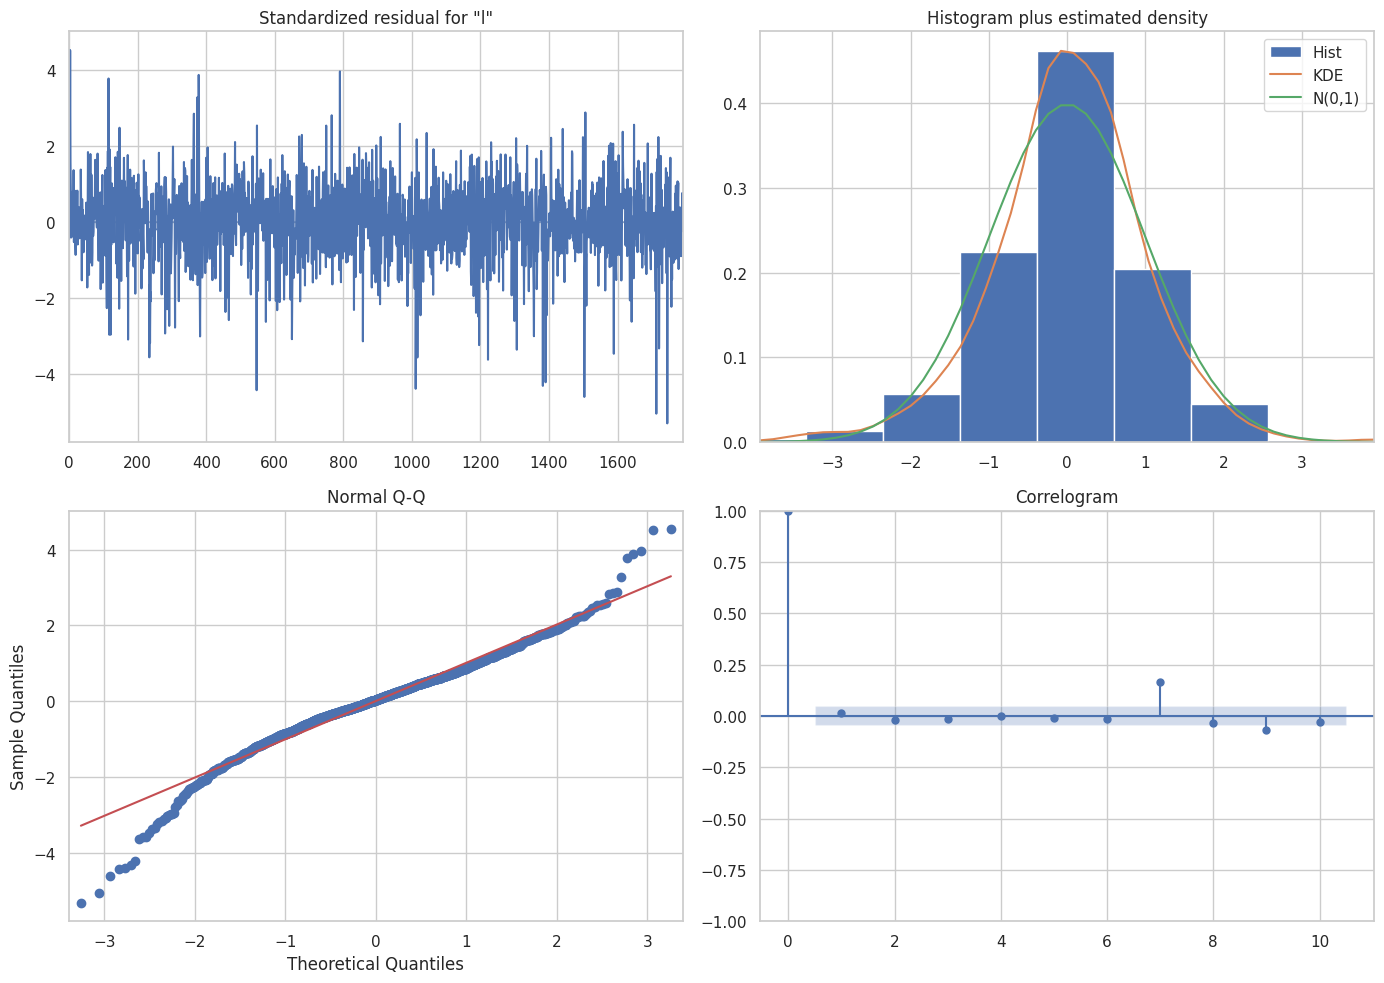

In [47]:
# Plot diagnostics to check model fit
arima_results.plot_diagnostics(figsize=(14, 10))
plt.tight_layout()
plt.show()

#### Results

**Model Interpretation**
The optimal model identified is ARIMA(5,1,1)(2,0,0)[7], which includes:

- First differencing (d=1) confirming our stationarity test results
- Five autoregressive terms with strong influence of immediate past values (AR1 coefficient = 0.9076)
- One moving average term with significant negative correction (-0.9238)
- Weekly seasonal pattern captured by AR terms at lags 7 and 14

**Diagnostic Checks**

The diagnostic plots and statistics indicate a good model fit:

- Residuals show no obvious patterns in the time plot
- The Ljung-Box test (Q=0.32, p=0.57) confirms no significant autocorrelation in residuals
- Residual autocorrelations in the correlogram are within significance bounds
- Histogram approximates normal distribution but with heavier tails (kurtosis=5.65) and slight negative skew (-0.45)
- The Jarque-Bera test (JB=584.92, p=0.00) formally confirms this deviation from normality
- Q-Q plot shows good conformity to normality except at extremes
- Heteroskedasticity test (H=1.03, p=0.69) indicates constant variance in residuals

**Conclusion**

The ARIMA(5,1,1)(2,0,0)[7] model effectively captures both short-term dependencies and weekly seasonal patterns in Houston's electricity load, with diagnostic checks confirming the model's suitability for forecasting future electricity consumption.

##   ARIMA Model Forecasting (Extra)

In [70]:
# Last date in the dataset
last_date = df.index[-1]  # Get the last date from the index

In [71]:
# Last date in the dataset
# Change this to get the last date from the 'date' column
last_date = df['date'].iloc[-1]

# Generate dates for the next 30 days
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

In [72]:
# Create forecast
forecast_results = arima_results.get_forecast(steps=30)
forecast_mean = forecast_results.predicted_mean
forecast_ci = forecast_results.conf_int()

In [73]:
# Plot the forecast
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

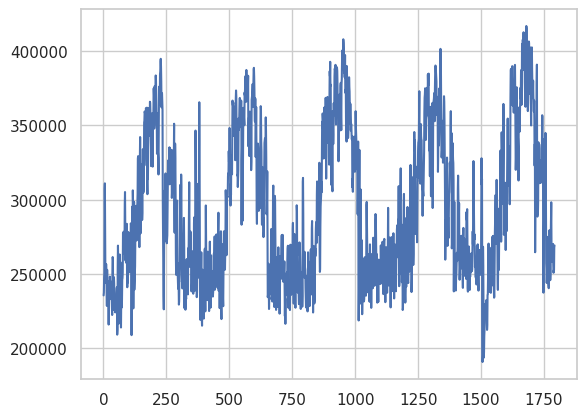

In [74]:
# Historical data
plt.plot(df.index, df['load'], label='Historical Data')

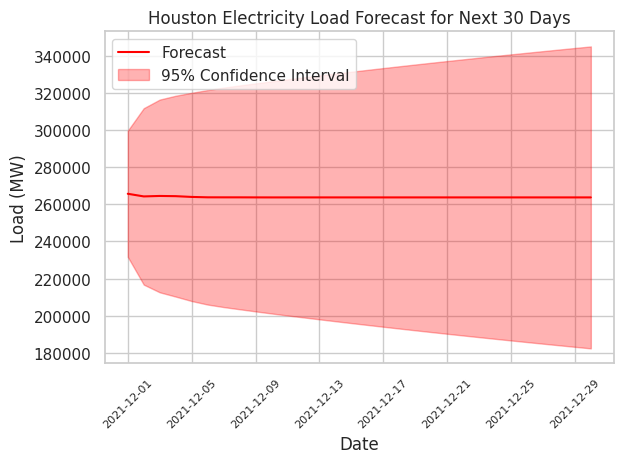

In [75]:
# Forecast
plt.plot(forecast_dates, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_dates,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')

plt.title('Houston Electricity Load Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)

# Set smaller font size for x-axis labels and rotate them
plt.xticks(fontsize=8, rotation=45)

plt.tight_layout()
plt.show()

In [76]:
# Create a DataFrame with forecast results
forecast_df = pd.DataFrame({
    'forecasted_load': forecast_mean,
    'lower_ci': forecast_ci.iloc[:, 0],
    'upper_ci': forecast_ci.iloc[:, 1]}, index=forecast_dates)

print("\nLoad Forecast for Next 30 Days:")
print(forecast_df.head(10))


Load Forecast for Next 30 Days:
            forecasted_load  lower_ci  upper_ci
2021-12-01              NaN       NaN       NaN
2021-12-02              NaN       NaN       NaN
2021-12-03              NaN       NaN       NaN
2021-12-04              NaN       NaN       NaN
2021-12-05              NaN       NaN       NaN
2021-12-06              NaN       NaN       NaN
2021-12-07              NaN       NaN       NaN
2021-12-08              NaN       NaN       NaN
2021-12-09              NaN       NaN       NaN
2021-12-10              NaN       NaN       NaN
